In [6]:
from symbolic_bounds import ProgramFactory
from symbolic_bounds.dag import DAG

# Test with simple DAG: X -> Y
print("="*80)
print("SIMPLE EXAMPLE: Z -> X -> Y")
print("="*80)

# Create a DAG
dag = DAG()

# Add binary nodes - all nodes must be assigned to a partition
# Z = dag.add_node('Z', support={0, 1}, partition='L')
X = dag.add_node('X', support={0, 1}, partition='L')
Y = dag.add_node('Y', support={0, 1}, partition='R')
# dag.add_edge(Z, Y)
dag.add_edge(X, Y)

dag.generate_all_response_types()
# dag.print_response_type_table(Z)
dag.print_response_type_table(X)
dag.print_response_type_table(Y)

constraints1 = ProgramFactory.write_constraints(dag)
constraints1.print_constraints(show_matrices=False, explicit_equations=True)

# print("\n\n")

# Test with complex DAG: Z -> X -> Y, Z -> Y
# print("="*80)
# print("COMPLEX EXAMPLE: Z -> X -> Y, Z -> Y")
# print("="*80)

# constraints2 = ProgramFactory.write_constraints(dag2)
# constraints2.print_constraints(show_matrices=False)

SIMPLE EXAMPLE: Z -> X -> Y

Response types for X (no parents):
r_X^1: X = 0
r_X^2: X = 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1

CONSTRAINT SYSTEM FROM ALGORITHM 1

                             Algorithm 1 Variables                              
--------------------------------------------------------------------------------
  ℵᴿ (aleph_R):      4  (number of response type combinations)
  B           :      4  (number of (W_L, W_R) configurations)
  dim(q)      :      4  (decision variable has 4 components)
  dim(p*)     :      4  (joint probability vector)
  |W_L configs|:      2  (number of distinct W_L configurations)
  dim(p|W_L)  :      2  (conditional prob. vector per W_L config)

                               Matrix Dimensions                                
--------------------------------------------------------------------------------
  P matri

In [52]:
print(constraints1.P)

[[1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]


In [4]:
# =========================================================================
# ALGORITHM 1 - INITIALIZATION: Enumerate response types for all vertices
# =========================================================================
# For each vertex, enumerate all response types
import itertools
from symbolic_bounds.constraints import Constraints
import numpy as np
from symbolic_bounds.dag import DAG
import symbolic_bounds.program_factory as ProgramFactory

dag = DAG()

X = dag.add_node('X', support={0, 1}, partition='L')
Y = dag.add_node('Y', support={0, 1}, partition='R')
dag.add_edge(X, Y)


constraints = Constraints()

all_response_types = dag.generate_all_response_types()

# Get all nodes (needed for compatibility checking)
all_nodes = sorted(dag.get_all_nodes(), key=lambda n: n.name)

# ℵᴿ = number of response type combinations for W_R ONLY (not all nodes!)
# q represents response type combinations for nodes in W_R
w_r_nodes = sorted(dag.W_R, key=lambda n: n.name)
w_r_response_type_lists = [all_response_types[node] for node in w_r_nodes]
w_r_response_type_combinations = list(itertools.product(*w_r_response_type_lists))

# ℵᴿ = |supp(R_R)| = number of response type combinations for W_R
aleph_R = len(w_r_response_type_combinations)

# Store index mapping: response type combination r_γ -> γ (0-indexed)
# Note: r_γ only includes response types for nodes in W_R
for gamma, rt_combo in enumerate(w_r_response_type_combinations):
    constraints.response_type_index[rt_combo] = gamma
    # Create human-readable label for r_γ (only W_R nodes)
    label_parts = []
    for node, rt in zip(w_r_nodes, rt_combo):
        rt_num = node.response_types.index(rt) + 1
        label_parts.append(f"r_{node.name}^{rt_num}")
    constraints.response_type_labels.append(", ".join(label_parts))

# =========================================================================
# ALGORITHM 1 - MAIN LOOP: for b ∈ {1, …, B} do
# =========================================================================
# Initialize P as a B × ℵᴿ matrix of 0s
# Initialize P* as a B × ℵᴿ matrix of 0s  
# Initialize Λ as a B × B matrix of 0s
# Where B = number of configurations (w_{b,L}, w_{b,R})
#
# The outer loop iterates over b (configurations)
# The inner loop iterates over γ (response type combinations for W_R)
# Generate all possible configurations (w_{b,L}, w_{b,R}) for b ∈ {1, ..., B}
all_supports = [node.support for node in all_nodes]
all_configs = list(itertools.product(*all_supports))

B = len(all_configs)  # Number of configurations
aleph_R = len(w_r_response_type_combinations)  # ℵᴿ = |supp(R_R)|

# Initialize matrices according to Algorithm 1
P = np.zeros((B, aleph_R))  # P as a B × ℵᴿ matrix of 0s
P_star = np.zeros((B, aleph_R))  # P* as a B × ℵᴿ matrix of 0s
Lambda = np.zeros((B, B))  # Λ as a B × B matrix of 0s
joint_prob_index = {}
joint_prob_labels = []

# Get W_L nodes to compute marginal probabilities
w_l_nodes = sorted(dag.W_L, key=lambda n: n.name)

# for b ∈ {1, …, B} do
for b, value_config in enumerate(all_configs):
    # Configuration (w_{b,L}, w_{b,R})
    config = tuple((node, value) for node, value in zip(all_nodes, value_config))
    joint_prob_index[config] = b
    
    # Create label for configuration b
    label = ", ".join(f"{node.name}={value}" for node, value in config)
    joint_prob_labels.append(label)
    
    # Extract w_{b,L} from the configuration
    config_dict = dict(config)
    w_b_L = tuple((node, config_dict[node]) for node in w_l_nodes)
    
    # for γ ∈ {1, …, ℵᴿ} do (γ indexes response type combinations for W_R only)
    for gamma, r_gamma_wr in enumerate(w_r_response_type_combinations):
        # Check if ω = w_{b,R} where ωᵢ := gᵂⁱ(w_{b,L}, r_γ) for i ∈ R
        # r_gamma_wr contains only response types for W_R nodes
        if ProgramFactory._is_compatible_wr(dag, all_nodes, all_response_types,
                                                w_r_nodes, r_gamma_wr, config):
            # if ω = w_{b,R} then:
            # P_{b,γ} := 1
            P[b, gamma] = 1.0
            
            # Λ_{b,b} := p{W_L = w_{b,L}}
            # P*_{b,γ} := p{W_L = w_{b,L}}
            # Note: These are placeholders - actual probability values
            # would be filled in when data is provided
            Lambda[b, b] = 1.0  # Placeholder
            P_star[b, gamma] = 1.0  # Placeholder

        
P

AttributeError: module 'symbolic_bounds.program_factory' has no attribute '_is_compatible_wr'

DAG Summary:
  Total nodes: 7
  W_L nodes (3): L0, L1, L2
  W_R nodes (4): R0, R1, R2, R3
  Edges (6):
    L0 -> L1
    L0 -> L2
    L0 -> R1
    L0 -> R3
    L2 -> R0
    R0 -> R2


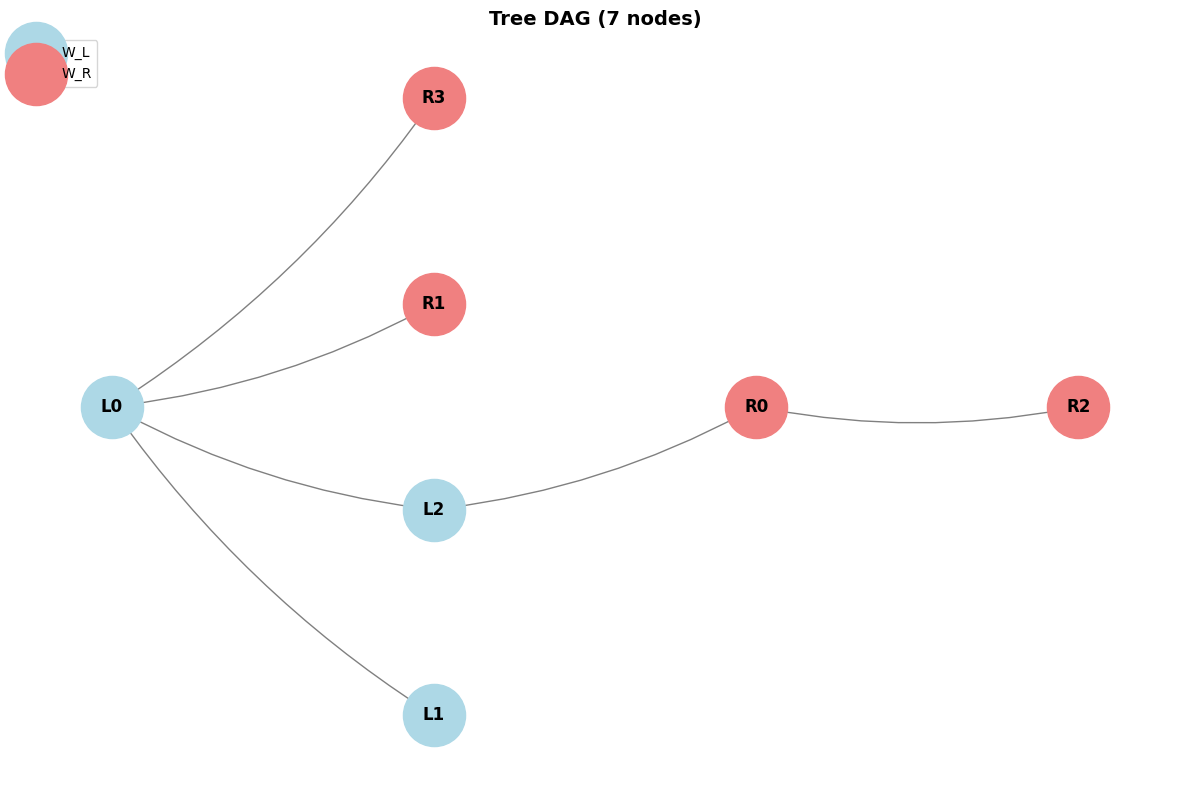

In [ ]:
from symbolic_bounds.dag import DAG
%load_ext autoreload
%autoreload 2


from symbolic_bounds.random_dag_generator import (
    generate_random_partitioned_dag, 
    generate_random_chain_dag,
    generate_random_tree_dag,
    print_dag_summary
)
import matplotlib.pyplot as plt



tree_dag = generate_random_tree_dag(n=7)
print_dag_summary(tree_dag)
fig3 = tree_dag.draw(figsize=(12, 8), title="Tree DAG (7 nodes)")
plt.show()
